<a href="https://colab.research.google.com/github/lupis30puc/yelp_bert_random_forest/blob/main/Yelp_polarity_preprocessing_for_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Yelp Polarity on kaggle](https://www.kaggle.com/irustandi/yelp-review-polarity)

1,569 samples from the Yelp Dataset Challenge 2015. This subset has 280,000 training samples and 19,000 test samples in each polarity.

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 5.8MB/s 
     |████████████████████████████████| 2.9MB 30.3MB/s 
     |████████████████████████████████| 890kB 48.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=5316d2a5e08ba909be3b57f9abfc99664c87c55bab59abb949d69c3f7eaca972
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Loading the datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import time
import re

In [ ]:
cols = ['label', 'text']
#df_1 = pd.read_csv('/content/drive/MyDrive/Yelp/train.csv', header=None, names= cols) #I'll do only test first, for time/resources purposes
df_2 = pd.read_csv('/content/drive/MyDrive/Yelp/test.csv', header=None, names=cols)

In [ ]:
# Originally 1 is negative and 2 is positive. I change it to 0 = negative and 1 = positive
#train_df = df_1.copy()
test_df = df_2.copy()

#train_df.label[train_df['label']== 1] = 0
#train_df.label[train_df['label']== 2] = 1
test_df.label[test_df['label']== 1] = 0
test_df.label[test_df['label']== 2] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#train_df.head()

In [ ]:
test_df.head()

,label,text
0,1,"Contrary to other reviews, I have zero complai..."
1,0,Last summer I had an appointment to get new ti...
2,1,"Friendly staff, same starbucks fair you get an..."
3,0,The food is good. Unfortunately the service is...
4,1,Even when we didn't have a car Filene's Baseme...


In [ ]:
#print('Train shape: ' + str(train_df.shape))
print('Test shape: ' + str(test_df.shape))

Test shape: (38000, 2)


### Tokenizing reviews to get the length 

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [ ]:
# creating a function to tokenize the reviews
def tokenize_text_in_df(dataframe):
  """
  The input df needs to have a 'text' column.
  With this function the df texts will be tokenized and we will obtain the text length in tokens.

  The output df will have 2 more columns:
    - 'tokenized'
    - 'len'

  """

  dataframe['tokenized'] = None #the text tokenized
  dataframe['len'] = None #length in tokens count
  
  for i in range(len(dataframe)):
    dataframe.tokenized[i] = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(dataframe.text[i]))
    dataframe.len[i] = len(dataframe.tokenized[i])
  
  return dataframe

In [ ]:
%%time
# inserting the tokenized reviews on a df
tokens_len_df = test_df.copy()
tokens_len_df = tokenize_text_in_df(tokens_len_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 2min 18s, sys: 257 ms, total: 2min 18s
Wall time: 2min 19s


In [ ]:
tokens_len_df.head()

,label,text,tokenized,len
0,1,"Contrary to other reviews, I have zero complai...","[10043, 2000, 2060, 4391, 1010, 1045, 2031, 57...",148
1,0,Last summer I had an appointment to get new ti...,"[2197, 2621, 1045, 2018, 2019, 6098, 2000, 213...",96
2,1,"Friendly staff, same starbucks fair you get an...","[5379, 3095, 1010, 2168, 29500, 4189, 2017, 21...",18
3,0,The food is good. Unfortunately the service is...,"[1996, 2833, 2003, 2204, 1012, 6854, 1996, 232...",61
4,1,Even when we didn't have a car Filene's Baseme...,"[2130, 2043, 2057, 2134, 1005, 1056, 2031, 103...",188


### EDA

Shape is: 38,000 reviews

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


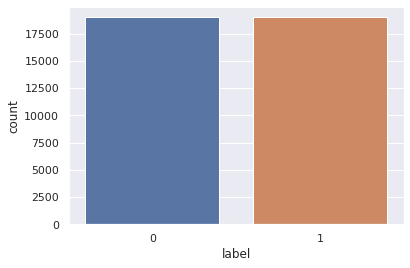

In [ ]:
# Checking the label distribbution
sns.countplot(tokens_len_df['label'])

In [ ]:
max(tokens_len_df['len'])

1518

CPU times: user 433 ms, sys: 103 ms, total: 536 ms
Wall time: 428 ms


<Figure size 864x648 with 0 Axes>

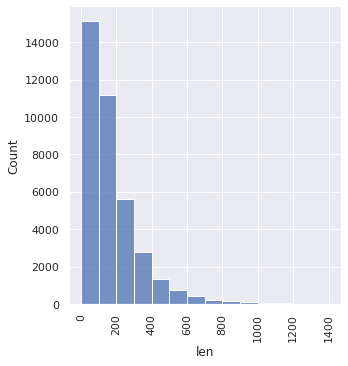

In [ ]:
%%time
# checking the reviews' length distribution
plt.figure(figsize=(12, 9))
plot = sns.displot(tokens_len_df['len'], bins=np.arange(0,1500,100))
plt.xticks(rotation=90)


In [ ]:
tokens_len_df['len'].describe(include='all')

count     38000
unique     1044
top          51
freq        206
Name: len, dtype: int64

In [ ]:
groupby1 = tokens_len_df.groupby(['label'])
groupby1.head()

,label,text,tokenized,len
0,1,"Contrary to other reviews, I have zero complai...","[10043, 2000, 2060, 4391, 1010, 1045, 2031, 57...",148
1,0,Last summer I had an appointment to get new ti...,"[2197, 2621, 1045, 2018, 2019, 6098, 2000, 213...",96
2,1,"Friendly staff, same starbucks fair you get an...","[5379, 3095, 1010, 2168, 29500, 4189, 2017, 21...",18
3,0,The food is good. Unfortunately the service is...,"[1996, 2833, 2003, 2204, 1012, 6854, 1996, 232...",61
4,1,Even when we didn't have a car Filene's Baseme...,"[2130, 2043, 2057, 2134, 1005, 1056, 2031, 103...",188
5,1,"Picture Billy Joel's \""Piano Man\"" DOUBLED mix...","[3861, 5006, 8963, 1005, 1055, 1032, 1000, 368...",273
6,0,Mediocre service. COLD food! Our food waited s...,"[19960, 3695, 16748, 2326, 1012, 3147, 2833, 9...",52
7,0,Ok! Let me tell you about my bad experience fi...,"[7929, 999, 2292, 2033, 2425, 2017, 2055, 2026...",412
8,0,I used to love D&B when it first opened in the...,"[1045, 2109, 2000, 2293, 1040, 1004, 1038, 204...",204
9,1,"Like any Barnes & Noble, it has a nice comfy c...","[2066, 2151, 9957, 1004, 7015, 1010, 2009, 203...",79


## Obtaining a sample

In [ ]:
# Trying out the df.sample()
sample_df = tokens_len_df.sample(n=10000, random_state=1)
sample_df.head(2)

,label,text,tokenized,len
25854,1,"Forget the rest, they're busy for a reason, I ...","[5293, 1996, 2717, 1010, 2027, 1005, 2128, 569...",38
4802,0,"So, I ordered delivery again. And, again, ever...","[2061, 1010, 1045, 3641, 6959, 2153, 1012, 199...",146


CPU times: user 566 ms, sys: 178 ms, total: 744 ms
Wall time: 549 ms


<Figure size 864x648 with 0 Axes>

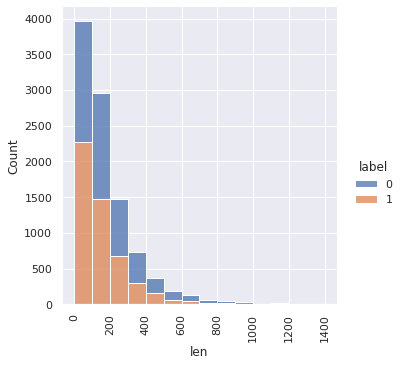

In [ ]:
%%time 
# checking the sample reviews' length distribution
plt.figure(figsize=(12, 9))
plot = sns.displot(data=sample_df, x='len', hue='label', multiple='stack', bins=np.arange(0,1500,100))
plt.xticks(rotation=90)

In [ ]:
"""
g = sns.FacetGrid(sample_df, col="label")
g.map_dataframe(sns.displot, x="len",hue='label', bins=np.arange(0,1500,100))
g.set_axis_labels("len", "count")
g.add_legend()
# 0 in negative, 1 is positive
"""

In [ ]:
sample_df['len'].describe()

count     10000
unique      791
top          77
freq         64
Name: len, dtype: int64

In [ ]:
max(sample_df['len'])

1417

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


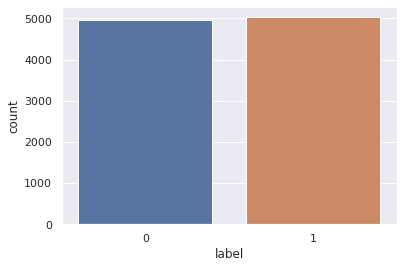

In [ ]:
# Checking the sample label distribution
sns.countplot(sample_df['label'])

In [ ]:
sample_df.to_csv('test_sample_10000.csv')

# On the preprocessing part we could erase blank spaces and other things that don't favor the texts for the model